In [1]:
import numpy as np
from scipy.io import loadmat,savemat
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from make_grid import make_coarser_grid,make_finer_grid
from grid_statistics import grid_roughness

In [2]:
data = loadmat('2m_gridded_bath.mat')
h = data['weak_h']
lat = data['lat']
lon = data['lon']

In [3]:
g100 = loadmat('ROXSI_grids_all.mat')['G100']
glat = np.rot90(g100['lat'][0][0])
glon = np.rot90(g100['lon'][0][0])
gh = g100['h'][0][0]

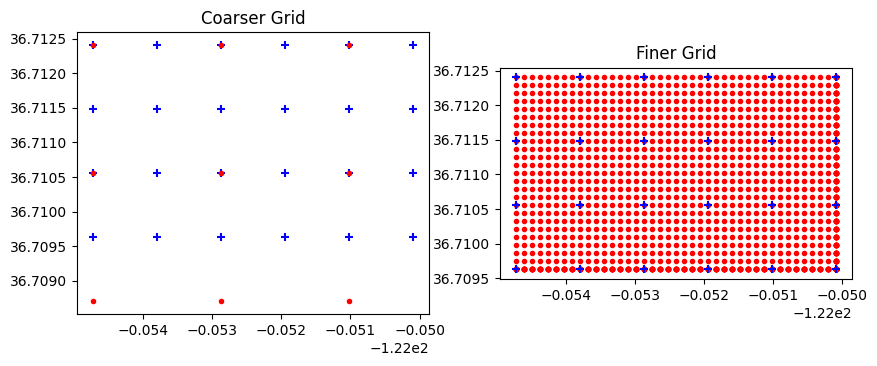

In [4]:
i_min,i_max = 91,135
j_min,j_max = 70,140

zoom = 12
cfact=2
ffact = 8
cglat,cglon=make_coarser_grid(glat[i_min//zoom:i_max//zoom+int(cfact),j_min//zoom:j_max//zoom],glon[i_min//zoom:i_max//zoom+int(cfact),j_min//zoom:j_max//zoom],cfact)

fglat,fglon=make_finer_grid(glat[i_min//zoom:i_max//zoom,j_min//zoom:j_max//zoom],glon[i_min//zoom:i_max//zoom,j_min//zoom:j_max//zoom],ffact)

fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].scatter(glon[i_min//zoom:i_max//zoom,j_min//zoom:j_max//zoom],glat[i_min//zoom:i_max//zoom,j_min//zoom:j_max//zoom],marker="+",c='b')
ax[0].scatter(cglon,cglat,marker='.',c='r')

ax[1].scatter(fglon,fglat,marker='.',c='r')
ax[1].scatter(glon[i_min//zoom:i_max//zoom,j_min//zoom:j_max//zoom],glat[i_min//zoom:i_max//zoom,j_min//zoom:j_max//zoom],marker="+",c='b')

titles = ['Coarser Grid','Finer Grid']

for a,t in zip(ax,titles):
    a.set_title(t)
    a.set_aspect('equal')
#     b=a.pcolormesh(lon,lat,h)
# plt.colorbar(b)

In [ ]:
mults = [-10,-8,-6,-5,-4,-3,-2,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
output = {}
for m in mults:
    
    if m < 0:
        new_lat,new_lon = make_finer_grid(glat[i_min:i_max,j_min:j_max],glon[i_min:i_max,j_min:j_max],abs(m))
        res = 100/abs(m)
        var_name='G{}'.format(str(int(res)))
        min_points = int((res/2)**2//4)
    else:
        new_lat,new_lon = make_coarser_grid(glat[i_min:i_max+int(m),j_min:j_max],glon[i_min:i_max+int(m),j_min:j_max],m)
        res = 100*m
        var_name='G{}'.format(str(int(res)))
        min_points = int((res/2)**2//4)   
        
    print(var_name)
    rgh,cell_h,b,n = grid_roughness(new_lat,new_lon,h,lat,lon,min_points)
        
    output[var_name+'rgh'] = rgh
    output[var_name+'h'] = cell_h
    output[var_name+'_lat'] = new_lat
    output[var_name+'_lon'] = new_lon

G10


In [ ]:
means = []
resol = []
stds = []
for m in mults:
    if m<0:
        res = 100/abs(m)
        key = 'G{}rgh'.format(str(int(res)))
    else:
        res = 100*m
        key = 'G{}rgh'.format(str(int(res)))
    stds.append(np.nanstd(output[key]))
    resol.append(res)
    means.append(np.nanmean(output[key]))

In [112]:
from scipy.optimize import curve_fit

def log_rgh(res,A,c):
    return A*np.log(np.array(res))+c
def lin_rgh(res,m,b):
    return m*np.array(res) + b 
plog,cov=curve_fit(log_rgh,resol[:9],means[:9])
plin,cov=curve_fit(lin_rgh,resol[8:],means[8:])

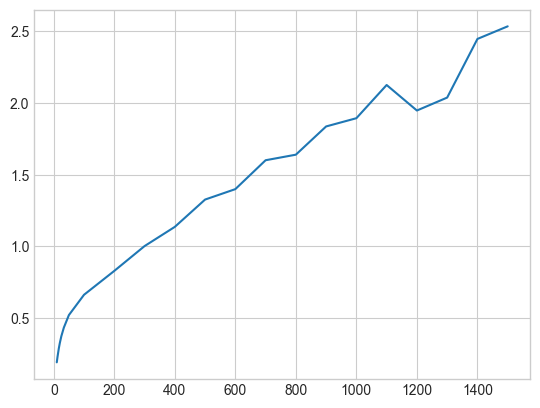

In [113]:
plt.plot(resol,means)

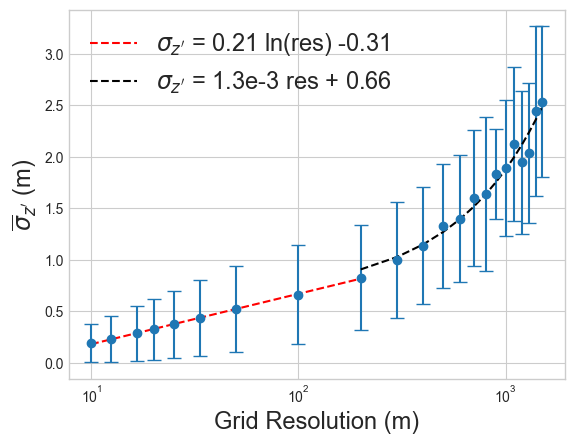

In [114]:
fs=17
plt.errorbar(resol,means,yerr=stds,fmt='o',capsize=5)
plt.plot(resol[:9],log_rgh(resol[:9],plog[0],plog[1]),'r--',
         label=r'$\sigma_{z^\prime}$'+' = {} ln(res) {}'.format(np.around(plog[0],2),np.around(plog[1],2)))
plt.plot(resol[8:],lin_rgh(resol[8:],plin[0],plin[1]),'k--',
        label=r'$\sigma_{z^\prime}$'+' = 1.3e-3 res + {}'.format(np.around(plin[1],2)))
plt.xscale('log')
plt.xlabel('Grid Resolution (m)',fontsize=fs)
plt.ylabel(r'$\overline{\sigma}_{z^\prime}$ (m)',fontsize=fs)
plt.legend(fontsize=fs)

plt.savefig('sigma_zprime_vs_gridres.png')

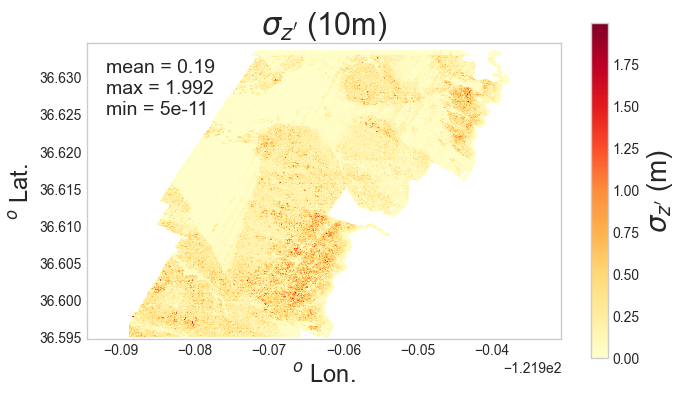

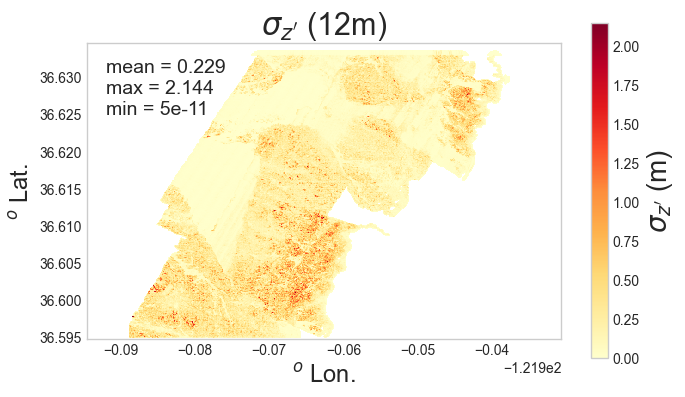

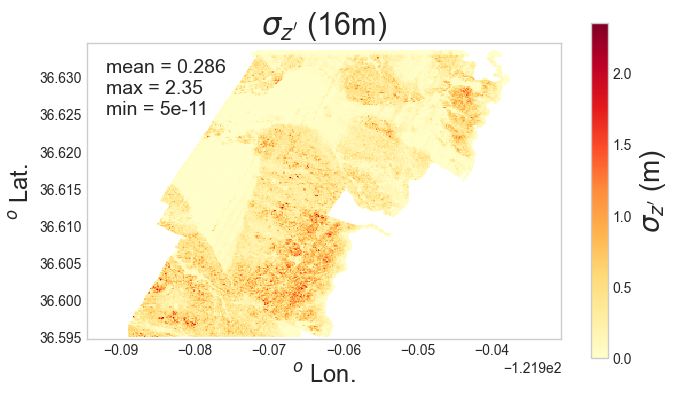

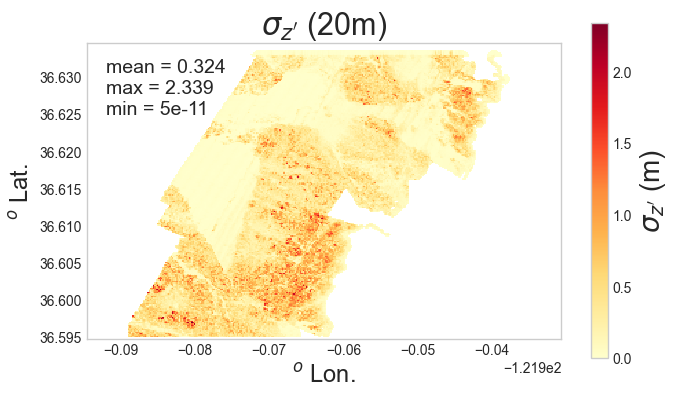

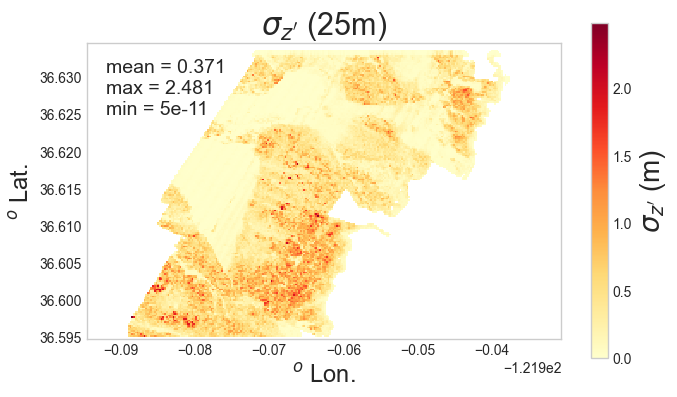

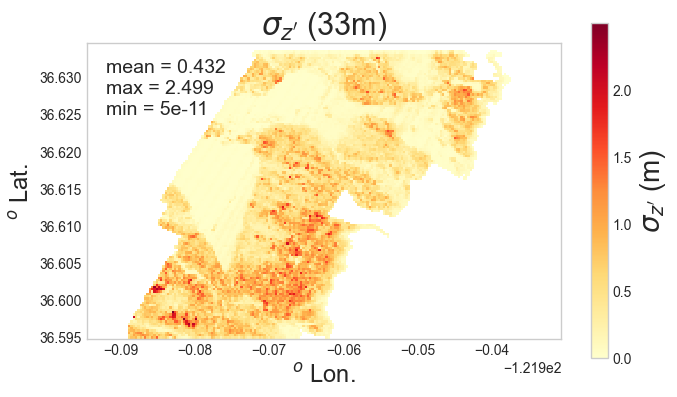

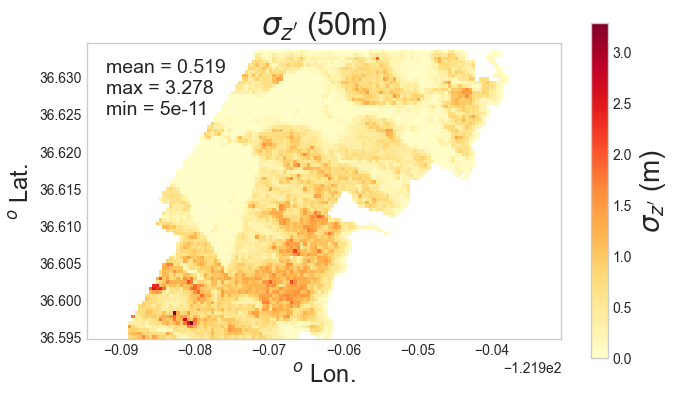

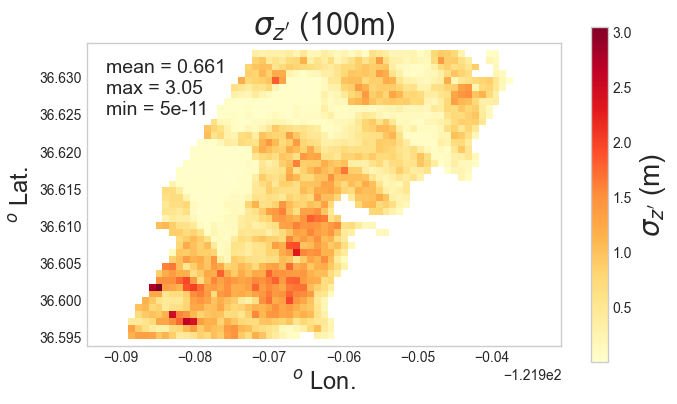

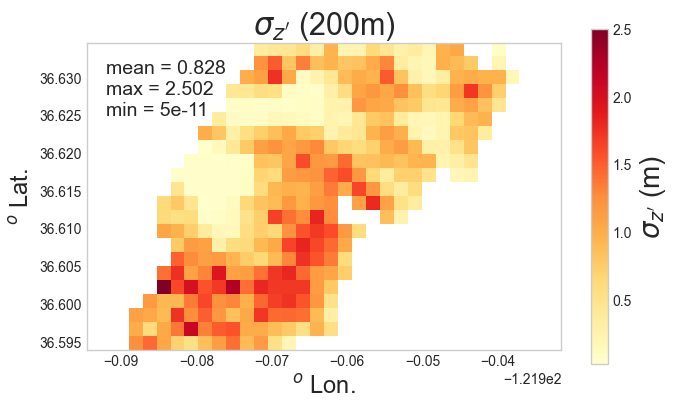

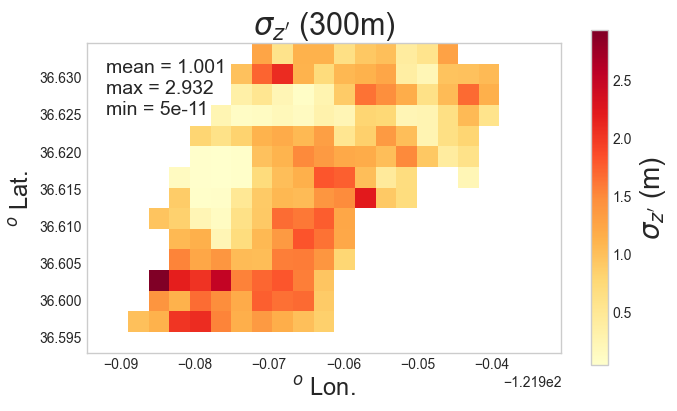

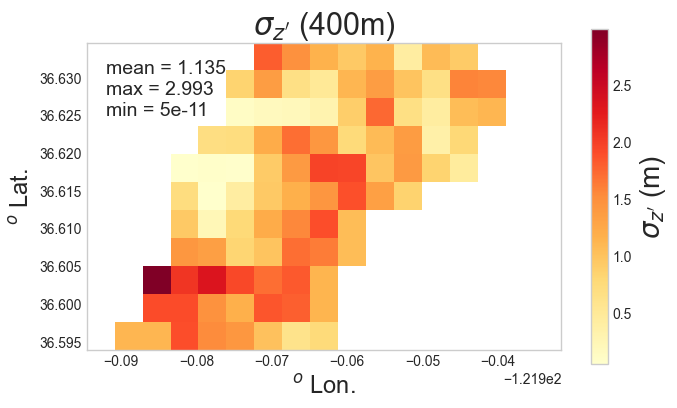

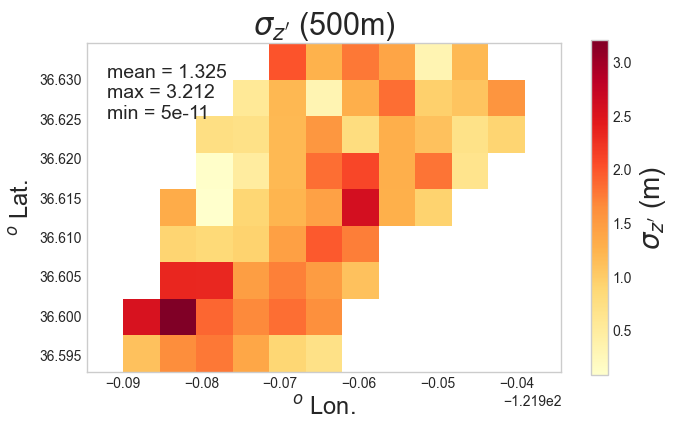

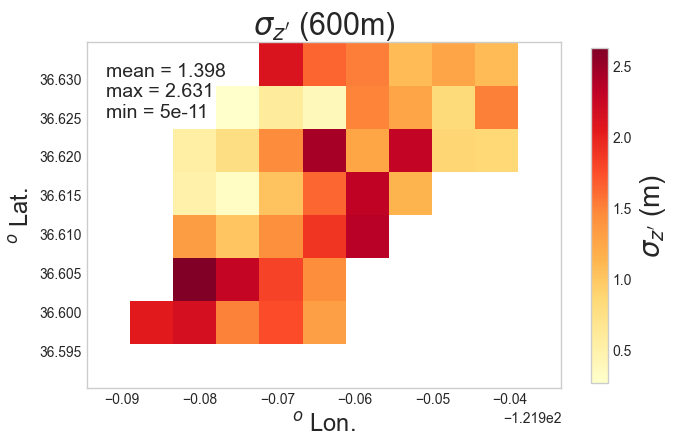

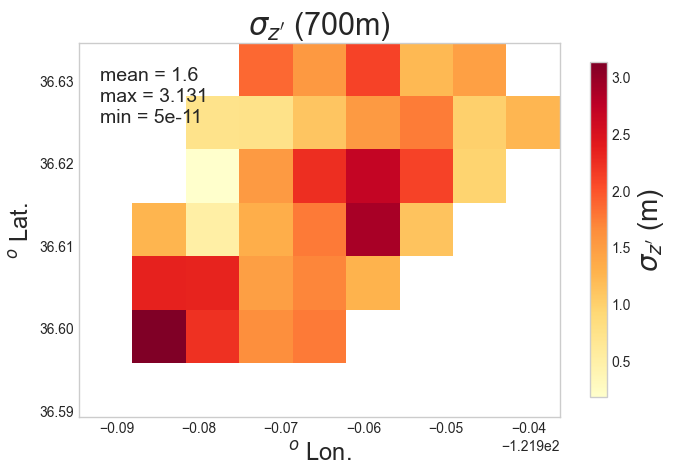

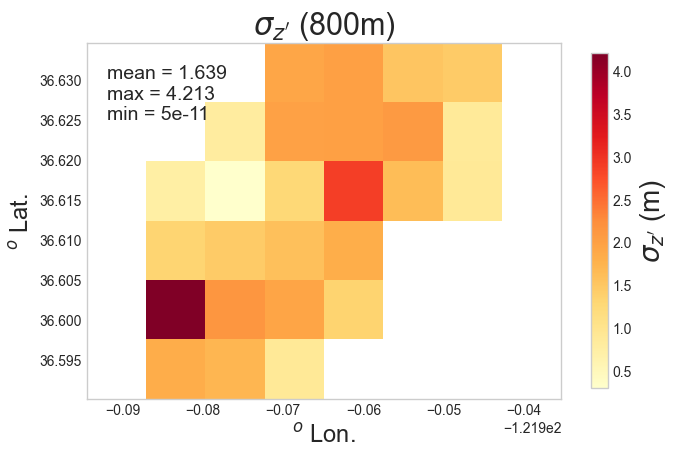

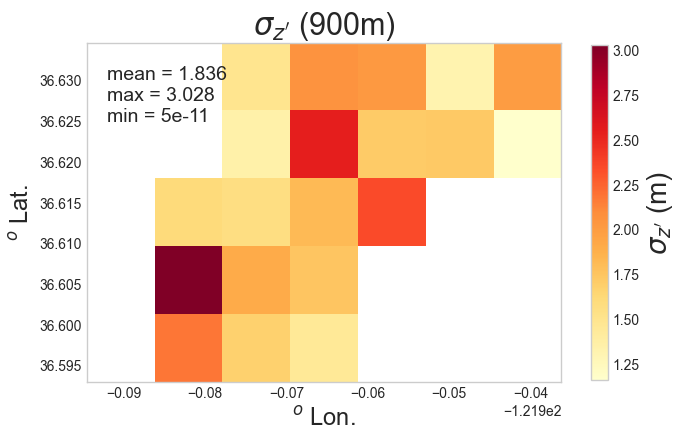

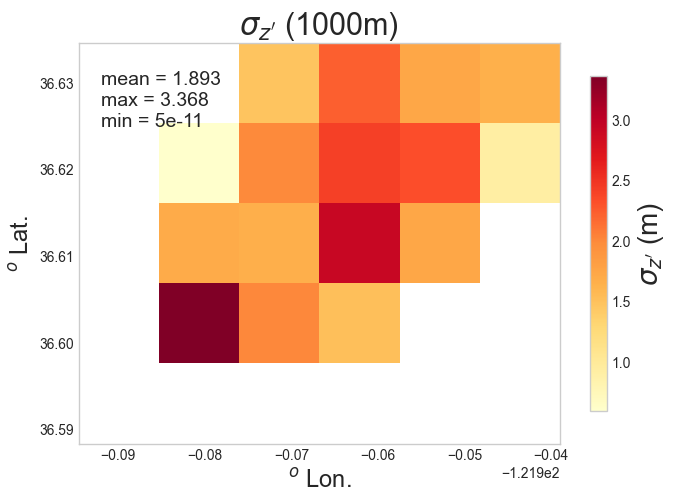

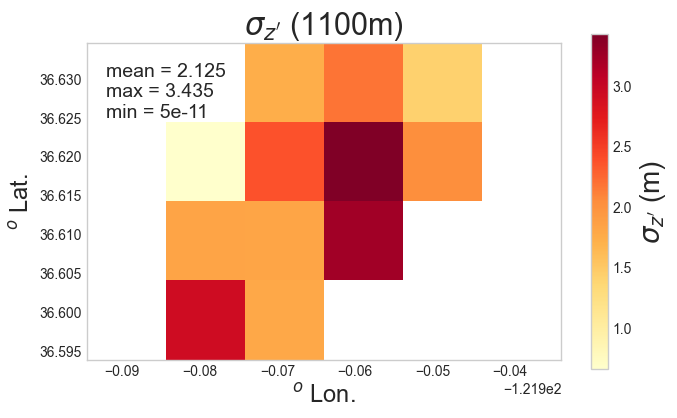

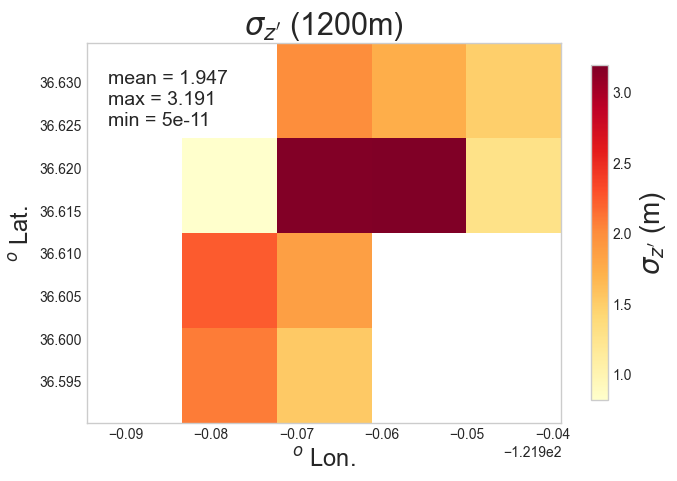

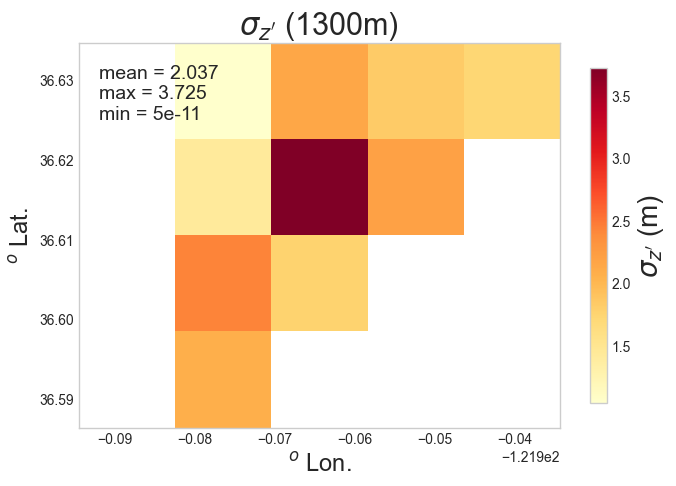

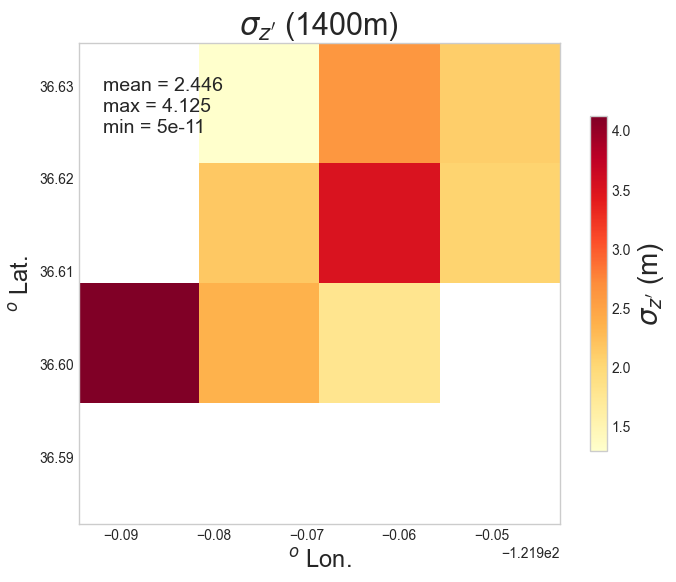

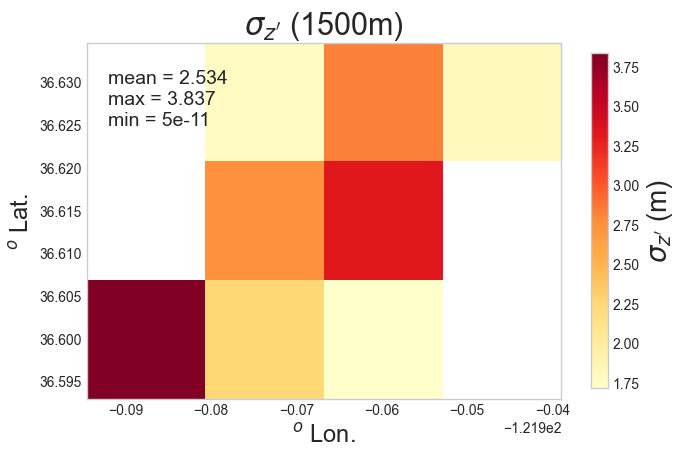

In [144]:

for gres in resol:
    
    fig,ax = plt.subplots(1,figsize=(7,7))
    fs = 17
    srk=.5
    res= 'G{}'.format(int(gres))

    a=ax.pcolormesh(output[res+'_lon'],
                   output[res+'_lat'],
                   output[res+'rgh'],cmap='YlOrRd')
    ax.set_title(r'$\sigma_{z^\prime}$'+' ({}m)'.format(int(gres)),fontsize=fs+5)
    cb =plt.colorbar(a,shrink=srk)
    cb.set_label(r'$\sigma_{z^\prime}$ (m)',fontsize=fs+3)



    ax.set_xlabel('$^o$ Lon.',fontsize=fs)
    ax.set_ylabel('$^o$ Lat.',fontsize=fs)
    ax.set_aspect('equal')

    text = "mean = {} \nmax = {} \nmin = 5e-11".format(np.around(np.nanmean(output[res+'rgh']),3),
                                                    np.around(np.nanmax(output[res+'rgh']),3))

    txt=ax.text(-121.992,36.625,text,fontsize=fs-3)

    fig.tight_layout()
    fig.savefig('figs/G{}m_sigma_zprime.png'.format(int(gres)))
    plt.show()

In [137]:
savemat('variable_grid_roughness.mat',output)